In [222]:
import os

from typing import Tuple
from numpy.typing import NDArray

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import mapvbvd

import pypulseq as pp

import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir))

sys.path.append(os.path.join(os.getcwd(), "Retrospective_study"))

import estimate_coil_sensitivity as csm
import function_reconstruction_spirale
import pynufft

import coil as calculate_coil_sens
import CG_signal

# Load acquisitions

In [2]:
path_to_data = os.path.join("/data_network/summer_projects", os.environ["USER"], "Current/2023_MRF_Collab/SIEMENS/Acquisitions")

In [3]:
lst_acquisitions = {
    "250514_GIN": [
        {"acq": "meas_MID00013_FID01799_pulseq", "Nslices": 1, "Npulses": 3, "Nshots": 64}, #cartesian
        {"acq": "meas_MID00017_FID01803_pulseq", "Nslices": 1, "Npulses": 1, "Nshots": 64}, #cartesian
        {"acq": "meas_MID00018_FID01804_pulseq", "Nslices": 1, "Npulses": 260, "Nshots": 32} #cartesian
    ],
    "250515_GIN": [
        {"acq": "meas_MID00013_FID01813_pulseq",  "Nslices": 1, "Npulses": 1, "Nshots": 64}, #cartesian
        {"acq": "meas_MID00017_FID01817_pulseq", "Nslices": 1, "Npulses": 1, "Nshots": 64},
        {"acq": "meas_MID00018_FID01818_pulseq", "Nslices": 1, "Npulses": 1, "Nshots": 64},
        {"acq": "meas_MID00019_FID01819_pulseq", "Nslices": 1, "Npulses": 1, "Nshots": 64}
    ],
    "250516_GIN": [
        {"acq": "meas_MID00027_FID01841_pulseq_1_1pulse_res64_spiral_4shots_TR21_TE5", "Nslices": 1, "Npulses": 1, "Nshots": 4},
        {"acq": "meas_MID00028_FID01842_pulseq_2_1pulse_res64_spiral_4shots_TR30_TE10", "Nslices": 1, "Npulses": 1, "Nshots": 4},
        {"acq": "meas_MID00029_FID01843_pulseq_3_1pulse_res128_spiral_4shots_TR21_TE5", "Nslices": 1, "Npulses": 1, "Nshots": 4},
        {"acq": "meas_MID00030_FID01844_pulseq_4_1pulse_res128_spiral_4shots_TR30_TE10", "Nslices": 1, "Npulses": 1, "Nshots": 4},
        {"acq": "meas_MID00031_FID01845_pulseq_5_1pulse_res128_spiral_10shots_TR21_TE5", "Nslices": 1, "Npulses": 1, "Nshots": 10},
        {"acq": "meas_MID00032_FID01846_pulseq_6_1pulse_res128_spiral_10shots_TR21_TE5_SP", "Nslices": 1, "Npulses": 1, "Nshots": 10},
        {"acq": "meas_MID00033_FID01847_pulseq_7_5pulses_res64_spiral_4shots_TR21_TE5", "Nslices": 5, "Npulses": 1, "Nshots": 4},
        {"acq": "meas_MID00034_FID01848_pulseq_8_5pulses_res64_spiral_4shots_TR30_TE10", "Nslices": 5, "Npulses": 1, "Nshots": 4},
        {"acq": "meas_MID00035_FID01849_pulseq_9_5pulses_res128_spiral_10shots_TR21_TE5", "Nslices": 5, "Npulses": 1, "Nshots": 10},
        {"acq": "meas_MID00036_FID01850_pulseq_10_MRF_bSSFP_res64_quad10_spiral_4shots", "Nslices": 1, "Npulses": 260, "Nshots": 4}
    ],
    "250519_GIN": [
        {"acq": "meas_MID00018_FID01864_pulseq_2_10pulses_res128_spiral_10shots_TR30_TE10", "Nslices": 1, "Npulses": 10, "Nshots": 10},
        {"acq": "meas_MID00019_FID01865_pulseq_3_10pulses_res128_spiral_10shots_TR30_TE10_1s", "Nslices": 1, "Npulses": 10, "Nshots": 10},
        {"acq": "meas_MID00017_FID01863_pulseq_1_1pulse_res128_spiral_10shots_TR30_TE10_3s", "Nslices": 3, "Npulses": 1, "Nshots": 10},
        {"acq": "meas_MID00020_FID01866_pulseq_4_10pulses_res128_spiral_10shots_TR30_TE10_3s", "Nslices": 3, "Npulses": 10, "Nshots": 10}
    ],
    "250520_GIN": [
        {"acq": "meas_MID00017_FID01879_pulseq_1_MRF_bSSFP_res128_TR24_TE5_quad10_spiral_1shot_3s", "Nslices": 3, "Npulses": 260, "Nshots": 1},
        {"acq": "meas_MID00018_FID01880_pulseq_2_MRF_bSSFP_res128_TR24_TE5_quad10_spiral_2shots_3s", "Nslices": 3, "Npulses": 260, "Nshots": 2},
        {"acq": "meas_MID00019_FID01881_pulseq_3_MRF_bSSFP_res128_TR24_TE5_quad10_spiral_3shots_3s", "Nslices": 3, "Npulses": 260, "Nshots": 3},
        {"acq": "meas_MID00020_FID01882_pulseq_4_MRF_bSSFP_res128_TR24_TE5_quad10_spiral_4shots_3s", "Nslices": 3, "Npulses": 260, "Nshots": 4},
        {"acq": "meas_MID00021_FID01883_pulseq_5_MRF_bSSFP_res128_TR24_TE5_quad10_spiral_6shots_3s", "Nslices": 3, "Npulses": 260, "Nshots": 6},
        {"acq": "meas_MID00022_FID01884_pulseq_6_MRF_bSSFP_res128_TR24_TE5_quad10_spiral_8shots_3s", "Nslices": 3, "Npulses": 260, "Nshots": 8},
        {"acq": "meas_MID00023_FID01885_pulseq_7_MRF_bSSFP_res128_TR24_TE5_quad10_spiral_9shots_3s", "Nslices": 3, "Npulses": 260, "Nshots": 9}
    ],
    "250521_GIN": [
        {"acq": "meas_MID00026_FID01907_pulseq_1_MRF_bSSFP_res64_TR24_TE5_quad10_spiral_4shots_1s", "Nslices": 1, "Npulses": 260, "Nshots": 4},
        {"acq": "meas_MID00027_FID01908_pulseq_2_MRF_bSSFP_res128_TR24_TE5_quad10_spiral_1shot_1s", "Nslices": 1, "Npulses": 260, "Nshots": 1},
        {"acq": "meas_MID00028_FID01909_pulseq_4_MRF_bSSFP_res128_TR24_TE5_quad10_spiral_1shot_6s", "Nslices": 6, "Npulses": 260, "Nshots": 1},
        {"acq": "meas_MID00029_FID01910_pulseq_8_MRF_bSSFP_res128_TR24_TE5_quad10_spiral_9shots_1s", "Nslices": 1, "Npulses": 260, "Nshots": 9}
    ],
    "250527_GIN": [
        {"acq": "meas_MID00017_FID01923_pulseq_1_MRF_bSSFP_res128_TR21_TE5_quad10_spiral_4shots_1s", "Nslices": 1, "Npulses": 260, "Nshots": 4},
        {"acq": "meas_MID00018_FID01924_pulseq_2_MRF_bSSFP_res128_TR21_TE5_quad10_spiral_6shots_1s", "Nslices": 1, "Npulses": 260, "Nshots": 6},
        {"acq": "meas_MID00019_FID01925_pulseq_3_MRF_bSSFP_res128_TR21_TE5_quad10_spiral_9shots_1s", "Nslices": 1, "Npulses": 260, "Nshots": 9},
        {"acq": "meas_MID00020_FID01926_pulseq_4_MRF_bSSFP_res128_TR21_TE5_quad10_spiral_12shots_1s", "Nslices": 1, "Npulses": 260, "Nshots": 12}
    ]
}

# Functions to read and reshape

In [4]:
def load_rawdata_and_traj(path_to_files: str) -> Tuple[NDArray[np.complex128], NDArray[np.float64]]:
    """ Load raw data and trajectory. 
    
    Parameters
    ----------
    path_to_files: str
        Path to the folder containing sequence (.seq) and SIEMENS data (.dat) files. 
    
    Returns
    -------
    rawdata: array of shape (Nadcs, Ncoils, Nacqs)
        Raw data. 
    traj: array of shape (3, Nadcs*Nacqs)
        Trajectory. 
    """

    # raw data
    dat_file = [f for f in os.listdir(path_to_files) if f.endswith(".dat")][0]
    Siemens_file = mapvbvd.mapVBVD(os.path.join(path_to_files, dat_file))
    Siemens_file.image.flagRemoveOS = False
    rawdata = Siemens_file.image[''][:, :, :, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].astype(np.complex128)

    # sequence
    seq_file = [f for f in os.listdir(path_to_files) if f.endswith(".seq")][0]
    seq = pp.Sequence()
    seq.read(os.path.join(path_to_files, seq_file))
    traj = seq.calculate_kspace()[0].astype(np.float64)

    return rawdata, traj

def reshape_rawdata(rawdata: NDArray[np.complex128], 
                    Nslices: int, 
                    Npulses: int, 
                    Nshots: int
                    ) -> NDArray[np.complex128]:
    """ Reshape raw data. 
    
    Parameters
    ----------
    rawdata: array of shape (Nadcs, Ncoils, Nacqs)
        Raw data. 
    Nslices: int
        Number of slices. 
    Npulses: int
        Number of pulses. 
    Nshots: int
        Number of shots. 
    
    Returns
    -------
    reshaped_rawdata: array of shape (Nslices, Npulses, Ncoils, Nshots, Nadcs)
        Reshaped raw data. 
    """
    
    Nadcs, Ncoils, Nacqs = rawdata.shape
    assert Nacqs == Nslices*Npulses*Nshots, "Incoherent numbers of slices, pulses and shots."
    
    reshaped_rawdata = rawdata.reshape((Nadcs, Ncoils, Nslices, Nshots, Npulses))
    reshaped_rawdata = np.moveaxis(reshaped_rawdata, [0, 1, 2, 4], [4, 2, 0, 1])

    return reshaped_rawdata

def reshape_traj(traj: NDArray[np.float64], 
                 Nslices: int, 
                 Npulses: int, 
                 Nshots: int
                 ) -> NDArray[np.float64]:
    """ Reshape trajectory
    
    Parameters
    ----------
    traj: array of shape (3, Nslices*Npulses*Nshots*Nadcs)
        Trajectory. 
    Nslices: int
        Number of slices. 
    Npulses: int
        Number of pulses. 
    Nshots: int
        Number of shots. 
    
    Returns
    -------
    reshaped_traj: array of shape (3, Nslices, Npulses, Nshots, Nadcs)
        Reshaped raw data. 
    """
    
    Nadcs = traj.shape[1] // (Nslices*Npulses*Nshots)
    
    reshaped_traj = traj.reshape((3, Nslices, Nshots, Npulses, Nadcs))
    reshaped_traj = np.moveaxis(reshaped_traj, [2, 3], [3, 2])
    
    return reshaped_traj

# Le mieux c'est d'avoir une acquisition FS cartésienne à loader avec CARTESIAN RECO et de s'en servir pour la coil estimation. Si il n'y en a pas passer direct à SPIRAL et faire la NUFFT + SOS pour avoir une image cartésienne à passer dans coil sensitivity. De mes observations, ça aide pas mal de mettre un masque sur les cartes de sensibilités.

# CARTESIAN RECO

In [5]:
date = "250514_GIN"
acq = 1

path_to_files = os.path.join(path_to_data, date, lst_acquisitions[date][acq]["acq"])
Nslices, Npulses, Nshots = lst_acquisitions[date][acq]["Nslices"], lst_acquisitions[date][acq]["Npulses"], lst_acquisitions[date][acq]["Nshots"]

rawdata, traj = load_rawdata_and_traj(path_to_files)

rawdata = reshape_rawdata(rawdata, Nslices, Npulses, Nshots)
traj = reshape_traj(traj, Nslices, Npulses, Nshots)

pymapVBVD version 0.6.1
Software version: VB


In [6]:
# coil by coil reco
reco = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(rawdata, axes=(-2, -1))), axes=(-2, -1))

# SOS
R = np.sqrt(np.sum(abs(reco)**2, axis=2))

# MASK

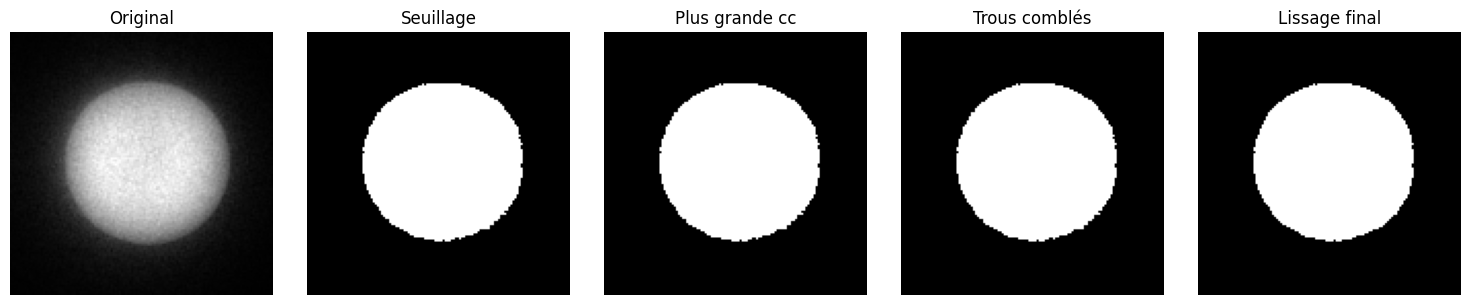

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, morphology, measure
from scipy import ndimage as ndi

img = np.abs(reco_sos[0, ])
th = filters.threshold_otsu(img)
mask = img > th

# 3) Sélection de la plus grande cc (pour ne garder que le grand anneau)
labels = measure.label(mask)
props  = measure.regionprops(labels)
# repérer la région de plus grande surface
largest_label = max(props, key=lambda x: x.area).label
mask_largest = (labels == largest_label)

# 4) Combler les trous à l’intérieur (pour avoir un solide, pas un anneau creux)
mask_filled = ndi.binary_fill_holes(mask_largest)

# 5) Fermeture morphologique large pour lisser & combler petits vides
#    ici un disque de rayon 10 (à ajuster selon la taille de ton anneau)
selem = morphology.disk(10)
mask_closed = morphology.binary_closing(mask_filled, selem)

# 6) (Optionnel) Érosion légère puis dilatation pour affiner
mask_clean = morphology.binary_opening(mask_closed, morphology.disk(3))

# Affichage
fig, axes = plt.subplots(1,5, figsize=(15,3))
axes[0].imshow(img,           cmap='gray'); axes[0].set_title('Original')
axes[1].imshow(mask,          cmap='gray'); axes[1].set_title('Seuillage')
axes[2].imshow(mask_largest,  cmap='gray'); axes[2].set_title('Plus grande cc')
axes[3].imshow(mask_filled,   cmap='gray'); axes[3].set_title('Trous comblés')
axes[4].imshow(mask_clean,    cmap='gray'); axes[4].set_title('Lissage final')
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()

# Coil sensitivity estimation

In [195]:
rawdata = np.asarray(R)

In [198]:
raw_data_processed = np.squeeze(rawdata)
#raw_data_processed = np.expand_dims(raw_data_processed,1)

In [199]:
raw_data_processed.shape

(4, 260, 128, 128)

In [204]:
sensitivities_maps = csm.estimate_sensitivity(np.fft.fftshift( np.fft.fft2(np.fft.fftshift(raw_data_processed, axes=(-2, -1))), axes=(-2, -1)))*mask_clean

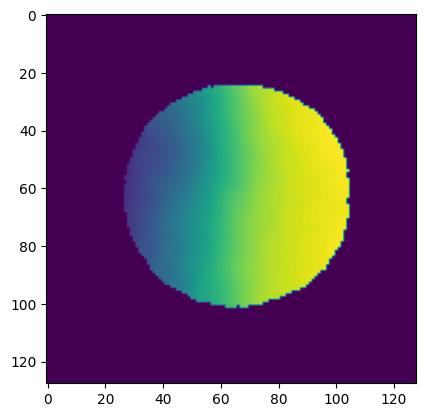

In [206]:
plt.imshow(np.abs(sensitivities_maps[0,:,:]))

## SPIRAL

In [210]:
date = "250527_GIN"
acq = 0

path_to_files = os.path.join(path_to_data, date, lst_acquisitions[date][acq]["acq"])
Nslices, Npulses, Nshots = lst_acquisitions[date][acq]["Nslices"], lst_acquisitions[date][acq]["Npulses"], lst_acquisitions[date][acq]["Nshots"]

rawdata, traj = load_rawdata_and_traj(path_to_files)

rawdata0 = np.copy(rawdata)

rawdata = reshape_rawdata(rawdata, Nslices, Npulses, Nshots)
traj = reshape_traj(traj, Nslices, Npulses, Nshots)

pymapVBVD version 0.6.1
Software version: VB


# NUFFT

In [179]:
from joblib import Parallel, delayed

In [183]:
def process_nufft(pulse, traj_spirale_norma, ksp):

    om = traj_spirale_norma[pulse,:,:]

    Nd = (128, 128)
    Kd = (128*2, 128*2)
    Jd = (6, 6)

    y_nufft_coils = np.zeros((4,128,128), dtype=complex)

    obj_nufft = pynufft.NUFFT()
    obj_nufft.plan(om, Nd, Kd, Jd)

    for coil in range (4):
        y_nufft = obj_nufft.solve(ksp[coil,pulse,:], solver='cg', maxiter=2)
        y_nufft_coils[coil,:,:] = y_nufft

    return pulse, y_nufft_coils


def parallel_process(ksp, traj_spirale_norma):
    y_nufft_sum = np.zeros((4,260,128,128), dtype=complex)  
    
    results = Parallel(n_jobs=-1)(delayed(process_nufft)(pulse, traj_spirale_norma, ksp) for pulse in range(260))  
                                  
    for pulse, nufft in results:
        y_nufft_sum[:,pulse,:,:] = nufft
    
    return y_nufft_sum


In [184]:
R = parallel_process(rawdata_slice, traj_slice)

In [185]:
reco_sos = np.sqrt(np.sum(np.abs(R)**2, axis=(0))) 

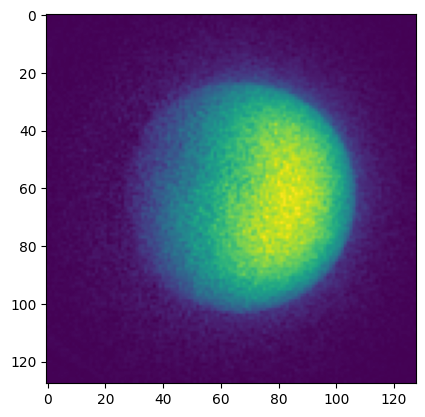

In [208]:
plt.imshow(np.abs(R[0,0,:,:]))

# CG-SENSE

In [212]:
#To obtain shape (n_coils, n_pulses, ninterleaves * trajectory.shape[1])

rawdata_slice = rawdata[0,:,:,:]
rawdata_slice = np.transpose(rawdata_slice, (1, 0, 2,3))

rawdata_slice = rawdata_slice.reshape(4, 260, -1, 1)
rawdata_slice = np.squeeze(rawdata_slice, axis =-1)

In [213]:
traj_slice = traj[0:2,0,:,:]
traj_slice = traj_slice.reshape(2, 260, -1, 1)
traj_slice = np.squeeze(traj_slice, axis = -1)
traj_slice = np.transpose(traj_slice, (1,2, 0))
traj_slice = traj_slice*np.pi / np.max(traj_slice)

In [ ]:
sensitivities_map = tf.cast(sensitivities_maps, tf.complex64)

In [219]:
cg_reco = function_reconstruction_spirale.spiral_reconstruction(image=None, k_space=rawdata_slice, trajectory=traj_slice, full_trajectory = True, sensitivity_map=sensitivities_map.numpy(), n_iters=2
                                                                , f_sampling=None, R=None, ninterleaves=None, alpha=None, spiral_rotation=True, return_trajectory=False)

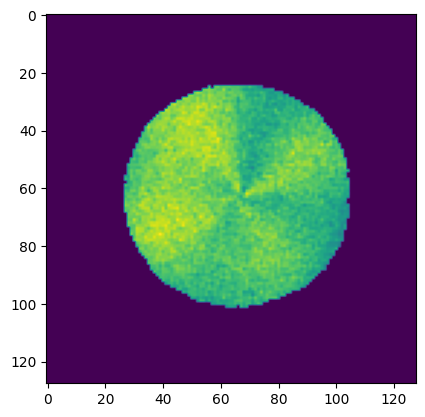

In [220]:
plt.imshow(np.abs(cg_reco[0, :, :]))

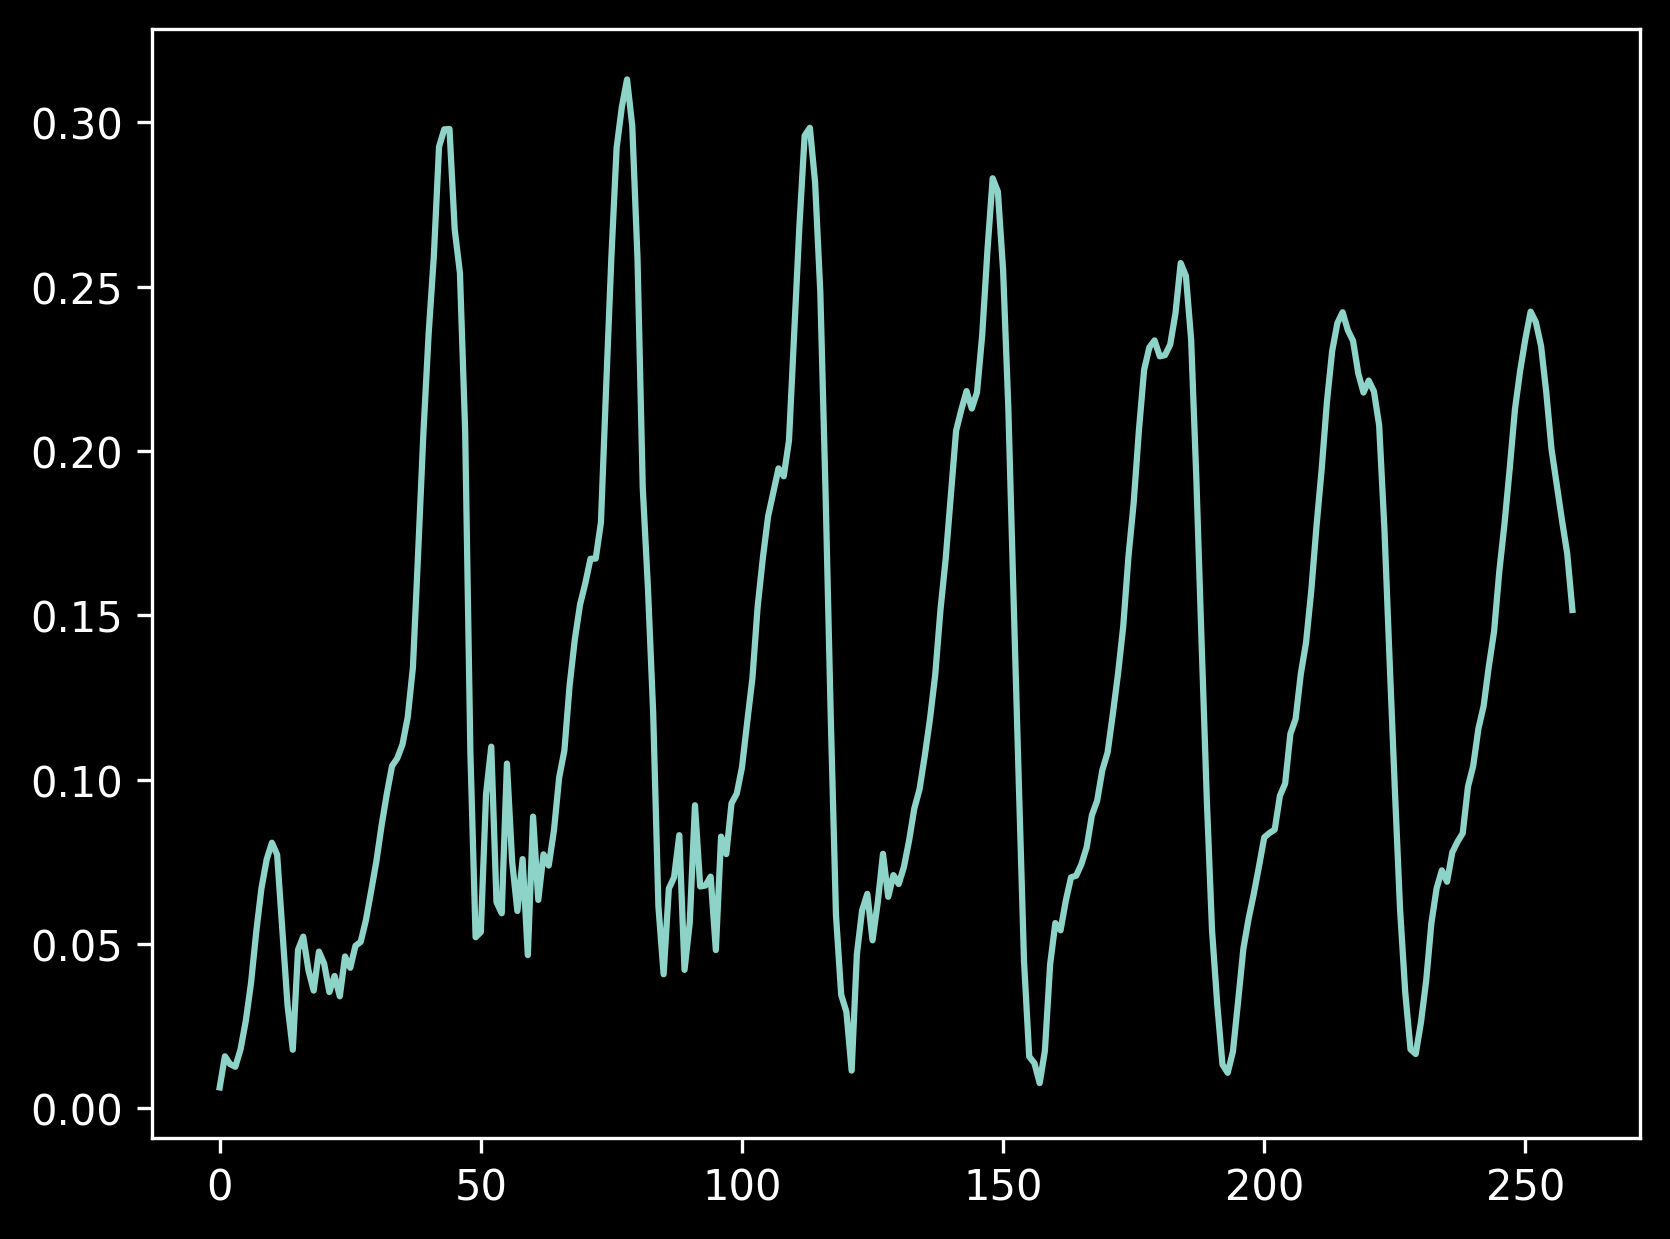

In [24]:
plt.plot(np.abs(cg_reco[:,30,30]))

# MARVEL

In [1]:
import json
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))

import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
#from tensorflow.keras.optimizers.legacy import Adam

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
   tf.config.experimental.set_memory_growth(gpu, True)

from time import time

import typing

import warnings
warnings.filterwarnings("ignore")

from Tools.load_save_utils import load_matlab_dictionary, load_hdf5_dictionary, remove_parameters_from_dictionary, save_model_weights, load_acquisition_reconstruction_from_nii, load_model_weights, _get_brain_acquisition_limits
from Tools.other_tools import print_time
from Tools.reconstruction_utils import compute_train_test_data, NN_prediction, NN_prediction_with_B1
from Neural_Networks.networks import *
from Tools.plot_utils import plot_parameter_maps_several_slices2
from Neural_Networks.networks_new import initialize_network
from Neural_Networks.networks_subspace import initialize_network as initialize_AE_network

sys.path.append(os.path.join(os.getcwd(), "CG-SENSE"))
from cg_sense_new_version import * 
import pynufft
#import functions
from numba import jit, prange
from joblib import Parallel, delayed

2025-05-23 18:33:26.216579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-23 18:33:26.237784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-23 18:33:26.244405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 18:33:26.262788: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-23 18:33:27.051253: W tensorflow/compiler/tf2

In [2]:
#Path to summer and to data
lst_trainings = [
    ('DICO8', 'train_updated_code_v2_LR0.9', '', 87),
]

path_to_summer_current = "/data_network/summer_projects/cungel/Current"

num_expe = -1

dico, expe, date, n_epochs = lst_trainings[num_expe]

training_path = os.path.join(dico, expe)

training_path = os.path.join(path_to_summer_current,'2023_MRF_Collab/Lila/MARVEL_training', training_path)

RECOS_INFOS = json.load(open(os.path.join(training_path, 'training_infos.json')))



In [3]:
# Initialize the network

n_pulses = 260

start = time()
print("\nINITIALIZE NETWORK")
NETWORK_INFOS = RECOS_INFOS["NETWORK_INFOS"]
learned_labels = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']
n_parameters = len(learned_labels)
layer_B1_constraint_incorporation = NETWORK_INFOS.get("incorporate_B1_constraint", False)

network_name = "BiLSTM"
input_size = n_pulses 
print(input_size)
layer_shapes = [input_size] + NETWORK_INFOS["hidden_layer_shapes"] + [n_parameters]
activations = NETWORK_INFOS["activations"]

NN = initialize_network(network_name, layer_shapes, activations, layer_B1_constraint_incorporation)

load_model_weights(NN, layer_shapes, adding_text='_{}epochs'.format(n_epochs), path_to_model=os.path.join(training_path, 'weights'))

NN.summary()


INITIALIZE NETWORK
260


2025-05-23 18:33:31.981376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 41617 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:25:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 260, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100)            │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75)             │         7,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         3,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,481 (126.88 KB)

 Trainable params: 32,481 (126.88 KB)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 


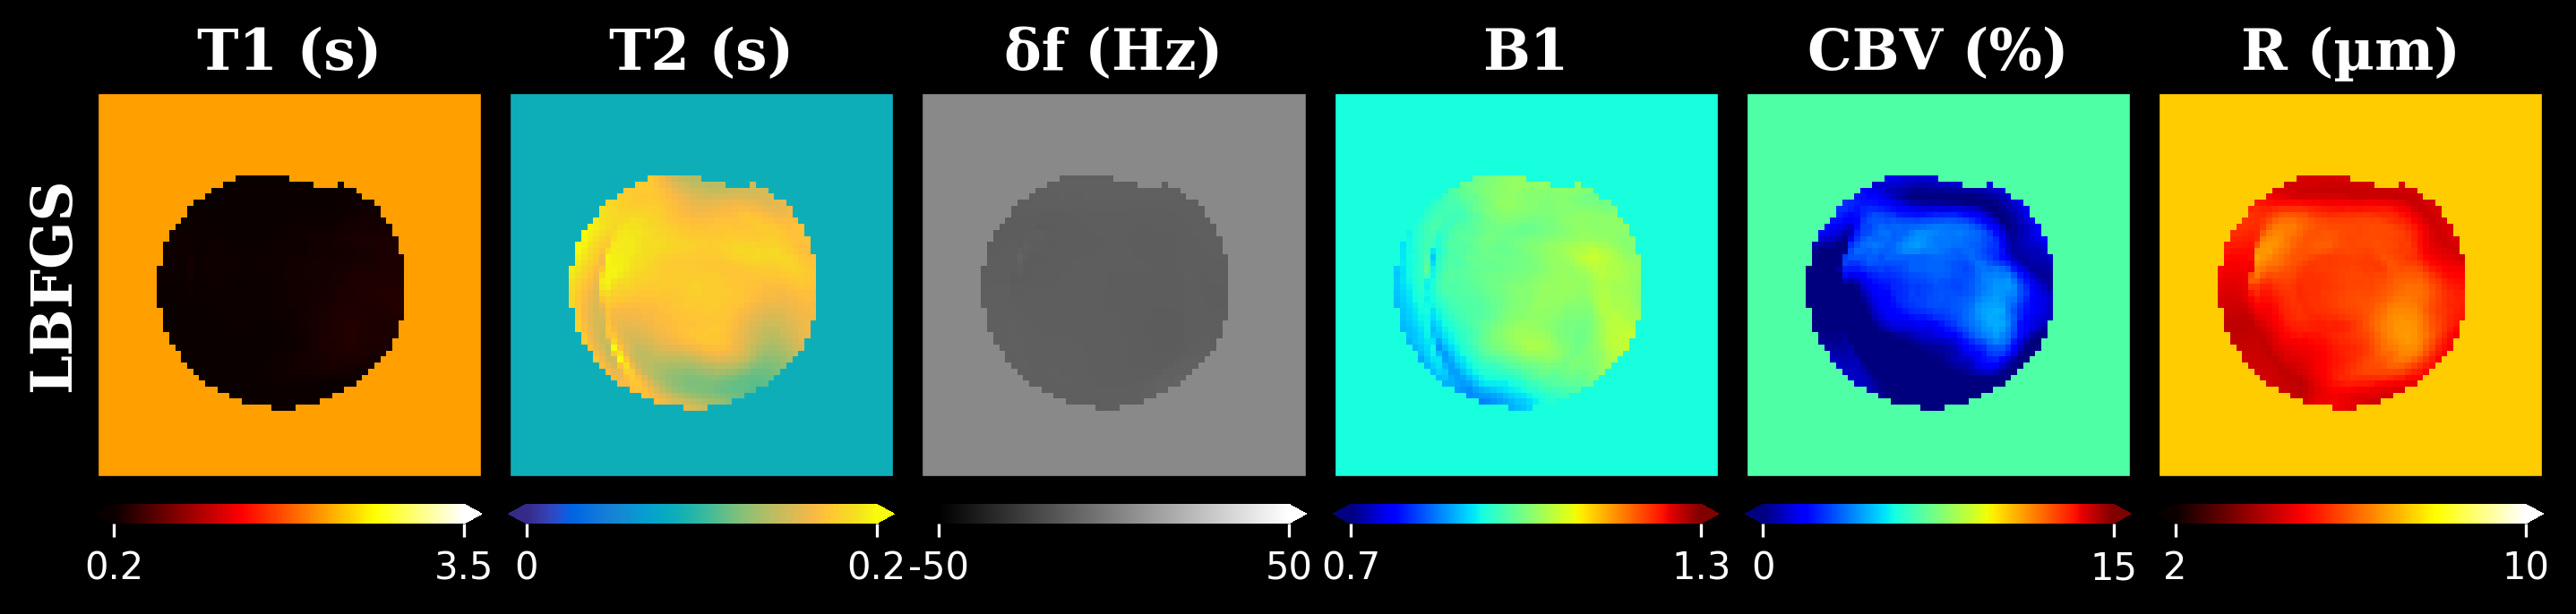

In [25]:
label_parameters = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']

cg_sense_array = cg_reco.numpy()
cg_sense_array =np.transpose(cg_sense_array, (1,2,0))
cg_sense_array = np.expand_dims(cg_sense_array, 2)


CG_reconstruction_rot = np.rot90(cg_sense_array,-1)
CG_reconstruction_norm = np.abs(CG_reconstruction_rot)/np.maximum(np.linalg.norm(np.abs(CG_reconstruction_rot), axis=3)[:, :, :, None], 1e-10)

NN_reconstruction_CG = NN_prediction(NN, CG_reconstruction_norm, label_parameters, batch_size=1024)

fig = plot_parameter_maps_several_slices2(NN_reconstruction_CG, label_parameters, title='', slice_titles = ['LBFGS'],path_to_data=training_path, file_name='{}_{}epochs'.format("first_test", n_epochs))